# Fetch Ordnance Survey (Open) Data

- Dowload files from OS OpenData API, save zip, open it in GeoPandas and dump to a PostGIS database.
- Process OS MasterMap Building height data

To establish a connection to the database, this notebook is using docker environment variables. Start docker as `docker run -it -e DB_PORT=<port> -e DB_USER=<username> -e DB_PWD=<password> -e DB_HOST=<host> darribas/gds_dev:5.0`.


In [1]:
import os
import zipfile
import requests

import fiona
import geopandas as gpd

from sqlalchemy import create_engine

## OpenRoads

### Download from API

Request the list of products available using Ordnance Survey API and filter `'OpenRoads'` record.

In [4]:
response = requests.get('https://api.os.uk/downloads/v1/products')
json = response.json()
for product in json:
    if product['id'] == 'OpenRoads':
        url = product['url']

In [3]:
roads = requests.get(url)
roads_json = roads.json()
roads_json

{'id': 'OpenRoads',
 'name': 'OS Open Roads',
 'description': 'Get a high-level view of the road network, from motorways to country lanes.',
 'version': '2020-04',
 'documentationUrl': 'https://www.ordnancesurvey.co.uk/business-government/products/open-map-roads',
 'dataStructures': ['Vector'],
 'category': 'Networks',
 'formats': [{'format': 'ESRI® Shapefile'},
  {'format': 'GML', 'subformat': '3'},
  {'format': 'GeoPackage'}],
 'url': 'https://api.os.uk/downloads/v1/products/OpenRoads',
 'imageCount': 3,
 'imageTemplate': 'https://api.os.uk/downloads/v1/products/OpenRoads/images/{index}',
 'downloadsUrl': 'https://api.os.uk/downloads/v1/products/OpenRoads/downloads',
 'areas': ['GB']}

Get download URLs.

In [4]:
download = requests.get(roads_json['downloadsUrl'])
download_json = download.json()
download_json

[{'md5': '60286049CB76C9D6364F0FE87090202C',
  'size': 541236838,
  'url': 'https://api.os.uk/downloads/v1/products/OpenRoads/downloads?area=GB&format=ESRI%C2%AE+Shapefile&redirect',
  'format': 'ESRI® Shapefile',
  'area': 'GB',
  'fileName': 'oproad_essh_gb.zip'},
 {'md5': '84E66CAFCEA9DD695A68540DE9379D4C',
  'size': 542188036,
  'url': 'https://api.os.uk/downloads/v1/products/OpenRoads/downloads?area=GB&format=GML&subformat=3&redirect',
  'format': 'GML',
  'subformat': '3',
  'area': 'GB',
  'fileName': 'oproad_gml3_gb.zip'},
 {'md5': 'E1FC93742CAAE7EF70C675749077AB42',
  'size': 931331115,
  'url': 'https://api.os.uk/downloads/v1/products/OpenRoads/downloads?area=GB&format=GeoPackage&redirect',
  'format': 'GeoPackage',
  'area': 'GB',
  'fileName': 'oproad_gpkg_gb.zip'}]

Save zipped GeoPackage to disk. Since we do not know its contents, we can't read it directly to GeoPandas.

In [5]:
for fileformat in download_json:
    if fileformat['format'] == 'GeoPackage':
        with open(fileformat['fileName'], "wb") as down:
            down.write(requests.get(fileformat['url']).content)
            down.close()

Explore the contents of the downloaded file.

In [6]:
gpkg = zipfile.ZipFile(fileformat['fileName'])
gpkg.namelist()

['readme.txt', 'data/oproad_gb.gpkg', 'doc/licence.txt']

Read GeoPackage to GeoPandas.

In [7]:
gdf = gpd.read_file('zip://' + fileformat['fileName'] + '!' + gpkg.namelist()[1])
gdf.head()

,id,endNode,startNode,roadNumberTOID,roadNameTOID,fictitious,roadClassification,roadFunction,formOfWay,length,...,loop,primaryRoute,trunkRoad,roadClassificationNumber,name1,name1_lang,name2,name2_lang,roadStructure,geometry
0,id04AE862E-2A92-41BC-BBE0-6AF05DDDE57E,idD6A4C11F-3E69-4E22-9711-2DE393FCF0A2,idF4241DAB-6DC5-4C0E-90FA-161BF2270663,None,None,False,Unknown,Minor Road,Single Carriageway,500,...,False,False,False,None,None,None,None,None,None,"LINESTRING (463181.000 1212313.000, 463361.630..."
1,idDF59D6BB-3E5C-4BFA-91E9-81FAFB70D79C,idE7211001-42DF-416C-9304-D39F9F66D4A6,id8F2F6CFE-2E3D-4CA3-AD41-124E098F7197,None,None,False,Unknown,Minor Road,Single Carriageway,525,...,False,False,False,None,None,None,None,None,None,"LINESTRING (464759.470 1212349.740, 464729.000..."
2,id92D440D3-B707-45F8-8173-E7EE22663573,idCB2E6127-8894-4372-8B1A-D8EECC2B6F8C,id9404ED22-2647-483C-81B6-C294CF3B8712,None,None,False,Unknown,Minor Road,Single Carriageway,338,...,False,False,False,None,None,None,None,None,None,"LINESTRING (463644.000 1212504.000, 463805.030..."
3,id7AA3E18E-21A4-4FD4-B308-EA0B3EA67046,id1CC69224-6F4C-4706-A658-2175240DE21A,id63BA7519-6915-4553-BEA5-AF9C57EF73A5,None,None,False,Unknown,Restricted Local Access Road,Single Carriageway,99,...,False,False,False,None,None,None,None,None,None,"LINESTRING (464193.000 1212455.000, 464217.080..."
4,idB9590DD5-48C1-47F6-9B1A-044C454CCB00,id63BA7519-6915-4553-BEA5-AF9C57EF73A5,idE7211001-42DF-416C-9304-D39F9F66D4A6,None,osgb4000000003210673,False,Unknown,Minor Road,Single Carriageway,104,...,False,False,False,None,Beach Road,None,None,None,None,"LINESTRING (464287.780 1212496.830, 464240.390..."


### Save GeoDataFrame to PostGIS

In [2]:
user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

In [3]:
db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

In [12]:
gdf.to_postgis("openroads_200803", engine, if_exists='replace')

## OpenMap - Local (building layer + barriers)
### Download from API

Now we get `url` of OpenMap - Local product, from which we extract buidling footprints and layers forming morphological barriers.


In [5]:
for product in json:
    if product['id'] == 'OpenMapLocal':
        url = product['url']
        print(url)

https://api.os.uk/downloads/v1/products/OpenMapLocal


Unlike above, OpenMap comes in split into tiles. We want the whole GB, so we have to specify it as `area`.


In [6]:
openmap = requests.get(url)
openmap_json = openmap.json()

download = requests.get(openmap_json['downloadsUrl'])
download_json = download.json()

for tile in download_json:
    if tile['area'] == 'GB' and tile['format'] == 'GML':
        url = tile['url']
        filename = tile['fileName']
        print(tile)

{'md5': '8D26A678FC6C0990633427519FF6F55D', 'size': 2239775851, 'url': 'https://api.os.uk/downloads/v1/products/OpenMapLocal/downloads?area=GB&format=GML&subformat=3&redirect', 'format': 'GML', 'subformat': '3', 'area': 'GB', 'fileName': 'opmplc_gml3_gb.zip'}


In [7]:
with open(filename, "wb") as down:
    down.write(requests.get(url).content)
    down.close()

### Save files to PostGIS

Because downloaded zip still containes data split into tiles, we will have to iterate over them and append them individually to the same table.



In [12]:
gml = zipfile.ZipFile(filename)
gml.namelist()

['/data/',
 '/doc/',
 '/doc/licence.txt',
 '/readme.txt',
 'data/HP/HP.gml',
 'data/HT/HT.gml',
 'data/HU/HU.gml',
 'data/HW/HW.gml',
 'data/HX/HX.gml',
 'data/HY/HY.gml',
 'data/HZ/HZ.gml',
 'data/NA/NA.gml',
 'data/NB/NB.gml',
 'data/NC/NC.gml',
 'data/ND/ND.gml',
 'data/NF/NF.gml',
 'data/NG/NG.gml',
 'data/NH/NH.gml',
 'data/NJ/NJ.gml',
 'data/NK/NK.gml',
 'data/NL/NL.gml',
 'data/NM/NM.gml',
 'data/NN/NN.gml',
 'data/NO/NO.gml',
 'data/NR/NR.gml',
 'data/NS/NS.gml',
 'data/NT/NT.gml',
 'data/NU/NU.gml',
 'data/NW/NW.gml',
 'data/NX/NX.gml',
 'data/NY/NY.gml',
 'data/NZ/NZ.gml',
 'data/OV/OV.gml',
 'data/SD/SD.gml',
 'data/SE/SE.gml',
 'data/SH/SH.gml',
 'data/SJ/SJ.gml',
 'data/SK/SK.gml',
 'data/SM/SM.gml',
 'data/SN/SN.gml',
 'data/SO/SO.gml',
 'data/SP/SP.gml',
 'data/SR/SR.gml',
 'data/SS/SS.gml',
 'data/ST/ST.gml',
 'data/SU/SU.gml',
 'data/SV/SV.gml',
 'data/SW/SW.gml',
 'data/SX/SX.gml',
 'data/SY/SY.gml',
 'data/SZ/SZ.gml',
 'data/TA/TA.gml',
 'data/TF/TF.gml',
 'data/TG/T

Since `gml` files come with more layers that we are looking for, let's explore them and pick only those of interest.


In [13]:
fiona.listlayers('zip://' + filename + '!' + gml.namelist()[-1])

['Building',
 'CarChargingPoint',
 'Foreshore',
 'FunctionalSite',
 'ImportantBuilding',
 'NamedPlace',
 'RailwayStation',
 'RailwayTrack',
 'Road',
 'Roundabout',
 'SurfaceWater_Area',
 'SurfaceWater_Line',
 'TidalBoundary',
 'TidalWater',
 'Woodland']

Finally, we can iterate over the contents of downloaded zip and store relevant data in our PostGIS table. Note the `if_exists='append` option, which ensures that we do not overwrite one tile with another. There are tiles covering only sea - those do not have wanted (e.g. `Building`) layer.


#### Buildings

In [18]:
for file in gml.namelist():
    if file.startswith('data/'):
        if 'Building' in fiona.listlayers('zip://' + filename + '!' + file):
            gdf = gpd.read_file('zip://' + filename + '!' + file, layer='Building')
            gdf.to_postgis("openmap_buildings_200814", engine, if_exists='append')
        else:
            print(file, 'does not contain Building layer.')

data/OV/OV.gml does not contain Building layer.


#### Railway

In [16]:
for file in gml.namelist():
    if file.startswith('data/'):
        if 'RailwayTrack' in fiona.listlayers('zip://' + filename + '!' + file):
            gdf = gpd.read_file('zip://' + filename + '!' + file, layer='RailwayTrack')
            gdf.to_postgis("openmap_railwaytrack_200824", engine, if_exists='append')
        else:
            print(file, 'does not contain Railway layer.')

data/HP/HP.gml does not contain Railway layer.
data/HT/HT.gml does not contain Railway layer.
data/HW/HW.gml does not contain Railway layer.
data/HX/HX.gml does not contain Railway layer.
data/HY/HY.gml does not contain Railway layer.
data/HZ/HZ.gml does not contain Railway layer.
data/NA/NA.gml does not contain Railway layer.
data/NB/NB.gml does not contain Railway layer.
data/NF/NF.gml does not contain Railway layer.
data/NL/NL.gml does not contain Railway layer.
data/NR/NR.gml does not contain Railway layer.
data/NW/NW.gml does not contain Railway layer.
data/OV/OV.gml does not contain Railway layer.
data/SR/SR.gml does not contain Railway layer.
data/SV/SV.gml does not contain Railway layer.


#### Surface Water

In [17]:
for file in gml.namelist():
    if file.startswith('data/'):
        if 'SurfaceWater_Area' in fiona.listlayers('zip://' + filename + '!' + file):
            gdf = gpd.read_file('zip://' + filename + '!' + file, layer='SurfaceWater_Area')
            gdf.to_postgis("openmap_surfacewater_area_200824", engine, if_exists='append')
        else:
            print(file, 'does not contain SurfaceWater_Area layer.')
        if 'SurfaceWater_Line' in fiona.listlayers('zip://' + filename + '!' + file):
            gdf = gpd.read_file('zip://' + filename + '!' + file, layer='SurfaceWater_Line')
            gdf.to_postgis("openmap_surfacewater_line_200824", engine, if_exists='append')
        else:
            print(file, 'does not contain SurfaceWater_Line layer.')

data/HW/HW.gml does not contain SurfaceWater_Line layer.
data/HX/HX.gml does not contain SurfaceWater_Area layer.
data/HX/HX.gml does not contain SurfaceWater_Line layer.
data/OV/OV.gml does not contain SurfaceWater_Area layer.
data/OV/OV.gml does not contain SurfaceWater_Line layer.


#### Woodland

In [18]:
for file in gml.namelist():
    if file.startswith('data/'):
        if 'Woodland' in fiona.listlayers('zip://' + filename + '!' + file):
            gdf = gpd.read_file('zip://' + filename + '!' + file, layer='Woodland')
            gdf.to_postgis("openmap_woodland_200824", engine, if_exists='append')
        else:
            print(file, 'does not contain Woodland layer.')

data/HT/HT.gml does not contain Woodland layer.
data/HW/HW.gml does not contain Woodland layer.
data/HX/HX.gml does not contain Woodland layer.
data/HZ/HZ.gml does not contain Woodland layer.
data/NA/NA.gml does not contain Woodland layer.
data/OV/OV.gml does not contain Woodland layer.


## Save samples of OS MasterMap Building height layer to parquet files

Processing raw downloads of OS MasterMap Building height layer from `digimap.edina.ac.uk` to a single parquet file per city. Initial downloaded zip files have been extracted and renamed to indicate the location. The contents of each folder is unchanged.

The structure of current directory:

```
notebook.ipynb
glasgow/*
leeds/*
edinburgh/*
manchester/*
liverpool/*
```

where `*` is the original content of downloaded zip file.

First we get the list of cities based on folders:


In [ ]:
cities = [city for city in glob.glob('**') if not city.endswith('ipynb')]

The data are stored in tiled `gdb` files which needs to be merged together first. We loop through `cities` and concatenate all `gdb` files in each into a single GeoDataFrame, which is then saved to a single parquet file.

In [ ]:
for city in cities:
    files = glob.glob(f'{city}/**/**/**')
    merged = pd.concat([gpd.read_file(file) for file in files if file.endswith('gdb')])
    merged.to_parquet(f'{city}.pq')

## Coastline

To get the external boundary of the GB, we will also need coastline geometry. That is downloadable from [data.gov.uk](https://data.gov.uk/dataset/26053db7-6caf-446f-8f7e-9775a19970e0/countries-december-2017-full-extent-boundaries-in-great-britain).

In [7]:
coastline = gpd.read_file('http://geoportal1-ons.opendata.arcgis.com/datasets/f2c2211ff185418484566b2b7a5e1300_1.zip?outSR={%22latestWkid%22:27700,%22wkid%22:27700}')

In [8]:
coastline

,objectid,ctry17cd,ctry17nm,ctry17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E92000001,England,Lloegr,394881,370341,-2.07813,53.230099,1.329461e+11,4.776071e+06,"MULTIPOLYGON (((398210.896 657405.599, 398214...."
1,2,S92000003,Scotland,Yr Alban,277746,700060,-3.97091,56.177429,8.022646e+10,1.790847e+07,"MULTIPOLYGON (((320228.803 976907.502, 320230...."
2,3,W92000004,Wales,Cymru,263406,242881,-3.99416,52.067410,2.122477e+10,2.027624e+06,"MULTIPOLYGON (((312661.601 385723.097, 312730...."


<AxesSubplot:>

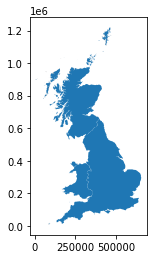

In [9]:
coastline.plot()

In [10]:
coastline.to_postgis("gb_countries_2017", engine, if_exists='replace')